In [1]:
import pyautogui
import os
import time
import pydirectinput
import numpy as np
from PIL import Image
import pytesseract
import re
import difflib
import logging
import pygetwindow as gw
import hashlib
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

        
first_rectangle_top_left_x = 477
first_rectangle_top_left_y = 1007
first_rectangle_bottom_right_x = 1001
first_rectangle_bottom_right_y = 1078

first_rectangle_top_right_x = 1012

width = first_rectangle_bottom_right_x - first_rectangle_top_left_x
height = first_rectangle_bottom_right_y - first_rectangle_top_left_y

class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def __str__(self):
        return f"Rectangle(x={self.x}, y={self.y}, width={self.width}, height={self.height})"
    

reference_rectangle_list = [
Rectangle(489,990, 1003 - 489, 1059 - 990),


Rectangle(489,1062, 1003 - 489, 1131 - 1062),


Rectangle(489,1133, 1003 - 489, 1202 - 1133),


Rectangle(489,1204, 1003 - 489, 1274 - 1204),

###

Rectangle(1017,990, 1553 - 1017, 1059 - 990),


Rectangle(1017,1062, 1553 - 1017, 1131 - 1062),


Rectangle(1017,1133, 1553 - 1017, 1202 - 1133),


Rectangle(1017,1204, 1553 - 1017, 1274 - 1204),

]

veriification_rectangle = Rectangle(467, 83, 657 - 467, 145 - 83)

exp_veriification_rectangle =  Rectangle(1578,751,2070-1578,1011-751)


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # replace with your actual path

custom_config = r'--tessdata-dir "C:\Program Files\Tesseract-OCR\tessdata" --psm 13'

def timer(seconds):
    # Start a 5-second timer
    for i in range(seconds, 0, -1):
        print(f"Remaining: {i} seconds")
        time.sleep(1)

def timed_input(seconds, key):
    pydirectinput.press(key)
    time.sleep(seconds)

counter = 0

class SkillAnalyzer():

    def __init__(self, recipe_controllers):

        self.recipe_controllers = recipe_controllers

    

    def check_window_change(self,active_window_title):
        # Check if the active window has changed
        if gw.getActiveWindow().title != active_window_title:
            print('Active window has changed. Stopping the program.')
            return True
        return False

        

    def define_verification_rectangle(self):
        verify_image = pyautogui.screenshot(region=(veriification_rectangle.x, veriification_rectangle.y, veriification_rectangle.width, veriification_rectangle.height))
        
        # Convert the image to bytes
        image_bytes = verify_image.tobytes()

        # Create a hash of the image
        image_hash = hashlib.sha256(image_bytes).hexdigest()

        self.verification_hash = image_hash

    def define_exp_verification_rectangle(self):
        verify_exp_image = pyautogui.screenshot(region=(exp_veriification_rectangle.x, exp_veriification_rectangle.y, exp_veriification_rectangle.width, exp_veriification_rectangle.height))

        verify_exp_image_bytes = verify_exp_image.tobytes()

        verify_exp_image_hash = hashlib.sha256(verify_exp_image_bytes).hexdigest()

        self.verification_hash_exp = verify_exp_image_hash




    def verify_rectangle(self):
        verify_image = pyautogui.screenshot(region=(veriification_rectangle.x, veriification_rectangle.y, veriification_rectangle.width, veriification_rectangle.height))


        verify_exp_image = pyautogui.screenshot(region=(exp_veriification_rectangle.x, exp_veriification_rectangle.y, exp_veriification_rectangle.width, exp_veriification_rectangle.height))
        
        # Convert the image to bytes
        image_bytes = verify_image.tobytes()

        verify_exp_image_bytes = verify_exp_image.tobytes()

        # Create a hash of the image
        image_hash = hashlib.sha256(image_bytes).hexdigest()

        verify_exp_image_hash = hashlib.sha256(verify_exp_image_bytes).hexdigest()

        if image_hash != self.verification_hash or verify_exp_image_hash != self.verification_hash_exp:
            if image_hash != self.verification_hash:
                print('Verification rectangle has changed. Stopping the program.')
                plt.imshow(verify_image)
            
            if verify_exp_image_hash != self.verification_hash_exp:
                print('EXP Verification rectangle has changed. Stopping the program.')
                plt.imshow(verify_exp_image)

            print('showing bad pictures')
            plt.show()
            return True

        return False


    def changeSpecialFusion(self):
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')
        # Press the 'l' key
        pydirectinput.press('l')
        # Press the 'm' key
        timed_input(0.1, 'm')
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')


    def change3wayFusion(self):
        for i in range(3):
            # Press the 'l' key
            timed_input(0.1, 'l')

        timed_input(0.1, 'm')
        
        for i in range(2):
            # Press the 'l' key
            #timed_input(0.1, 't')
            timed_input(0.1, 'g')
            
        
        timed_input(0.01, 'm')

        for i in range(1):
            # Press the 'l' key
            #timed_input(0.01, 't')
            timed_input(0.01, 'g')
            
        # Press the 'm' key
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')
        timed_input(0.1, 'm')
        pydirectinput.keyDown('up')
        pydirectinput.keyUp('up')

    def calculate_similarity_matrix(self,targets, references):
        matrix = np.zeros((len(targets), len(references)))
        for i, target in enumerate(targets):
            for j, reference in enumerate(references):
                score = difflib.SequenceMatcher(None, target, reference).ratio()
                matrix[i][j] = -score  # Negative score because we minimize cost
        return matrix
    
    def find_best_unique_matches(self,targets, references):
        similarity_matrix = self.calculate_similarity_matrix(targets, references)
        row_ind, col_ind = linear_sum_assignment(similarity_matrix)
        matches = {targets[i]: references[j] for i, j in zip(row_ind, col_ind)}
        sorted_matches = {target: matches[target] for target in targets if target in matches}

        return sorted_matches


    def get_images(self, recipe_controller,overall_counter):

        found_skills = []
        rec_counter = 0
        text_strips = []
        for rectangle in recipe_controller.rectangle_list:
        
            # Take a screenshot of the rectangle
            cropped_img = pyautogui.screenshot(region=(rectangle.x, rectangle.y, rectangle.width, rectangle.height))
            
            directory = "C:\\Users\\Eduardo\\Pictures\\Screenshots\\persona3\\{}\\{}\\{}\\".format(recipe_controller.logger_name,recipe_controller.result_persona_name, overall_counter)

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            image_path = directory + "{}.png".format(rec_counter)

            cropped_img.save(image_path)

            #plt.imshow(cropped_img)
            #plt.show()
            #test
            #cropped_img = img.crop((rectangle.x, rectangle.y, rectangle.x + rectangle.width, rectangle.y + rectangle.height))

            # Convert the image to RGB
            rgb_img = cropped_img.convert('RGB')

            hex_color = '65dfcd'

            # Convert the target hex color to RGB
            target_r, target_g, target_b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
            target_color = np.array([target_r, target_g, target_b])

            # Convert the image to a NumPy array
            img_array = np.array(rgb_img)

            # Calculate the Euclidean distance between each pixel's color and the target color
            color_distance = np.linalg.norm(img_array - target_color, axis=2)

            # Create a mask for pixels that are similar to the target color
            mask = color_distance < 65

            # Change the color of the pixels based on the mask
            img_array[mask] = [0, 0, 0]  # black
            img_array[~mask] = [255, 255, 255]  # white

            # Convert the NumPy array back to an image
            rgb_img = Image.fromarray(img_array)

            # Convert the image to grayscale
            gray_img = rgb_img.convert('L')

            # Apply a threshold to make it binary
            binary_img = gray_img.point(lambda x: 0 if x<128 else 255, '1')

            text_tesseract = pytesseract.image_to_string(binary_img, config=custom_config)
            
            # 'remove all characters that are not letters, numbers, ' ' or '-'
            text_re = re.sub(r'[^a-zA-Z0-9 -]', '', text_tesseract)

            # remove ' ' and '-' from the beginning and end of the string
            text_strip = text_re.strip(' -')


            text_strips.append(text_strip)

            rec_counter += 1

        
            ''' 
            match = difflib.get_close_matches(text_strip, recipe_controller.skill_set, n=1, cutoff=0.0)

            if match:
                best_match = match[0]
            else:
                best_match = ''  # No match found

            text_path = directory + "{}.txt".format(rec_counter)

            #write 'best_match' to a file
            with open(text_path, 'w') as file:
                file.write(best_match)

            rec_counter += 1
            found_skills.append(best_match)
            '''
        
        matches = self.find_best_unique_matches(text_strips, recipe_controller.skill_set)

        rec_counter = 0
        for target, match in matches.items():
            text_path = directory + "{}.txt".format(rec_counter)
            #write 'best_match' to a file
            with open(text_path, 'w') as file:
                file.write(match)
            found_skills.append(match)
            rec_counter += 1
            
        
        return found_skills
    
    def verify_duplicate(self, predictions):
        return len(predictions) != len(set(predictions))
        
    
    def cycle(self):
        global counter

        timer(3)
        # Press the right key
        #pydirectinput.keyDown('up')
        #pydirectinput.keyUp('up')
        # Get the title of the currently active window
        self.define_verification_rectangle()
        active_window_title = gw.getActiveWindow().title
        predict = True

        for recipe_controller in self.recipe_controllers:
            ''' 
            if recipe_controller.save_state_slot != 2 and recipe_controller.save_state_slot != 8:
                continue
            '''
            

            


            pydirectinput.keyDown(recipe_controller.save_state_slot_load)
            pydirectinput.keyUp(recipe_controller.save_state_slot_load)
            time.sleep(1)
            self.define_exp_verification_rectangle()
            counter = 0
            reoccuring_fail = False

            
            ''' 
            if recipe_controller.save_state_slot == 2:
                counter = 1000
            
            if recipe_controller.save_state_slot == 8:
                counter = 1000
            '''
            


            while counter < 1000:
                
                if self.check_window_change(active_window_title):
                    break

                if self.verify_rectangle():
                    pydirectinput.keyDown(recipe_controller.save_state_slot_load)
                    pydirectinput.keyUp(recipe_controller.save_state_slot_load)
                    predict = False
                    if reoccuring_fail:
                        break
                    reoccuring_fail = True
                    counter -=1
                #print("wating to save in key: ".format(recipe_controller.save_state_slot))
                pydirectinput.keyDown(recipe_controller.save_state_slot_save)
                pydirectinput.keyUp(recipe_controller.save_state_slot_save)

                predictions = self.get_images(recipe_controller,counter)
                
                if self.verify_duplicate(predictions):
                    predict = False
                    counter -=1
                    break

                # Log the predictions vector
                if predict:
                    reoccuring_fail = False
                    recipe_controller.logger.info(f'{predictions}')
                    print(predictions)
                else:
                    predict = True

                if self.check_window_change(active_window_title):
                    break
                
                if recipe_controller.fusion_spread_type == 'special':
                    self.changeSpecialFusion()
                    counter +=1
                elif recipe_controller.fusion_spread_type == '3way':
                    self.change3wayFusion()
                    counter +=1
            print('swaping to next save state')
        

        
class RecipeController():

    def __init__(self, persona_inherit_type,recipe_file_name,skill_set, base_skills_amount, inherit_slots_amount, result_persona_name, fusion_spread_type, save_state_slot ):

        # Unique logger name for each RecipeController instance
        logger_name = f'Logger_{recipe_file_name}_{save_state_slot}_{result_persona_name}'
        self.logger = logging.getLogger(logger_name)

        self.logger_name = logger_name

        # Prevent logger from propagating messages to ancestor loggers
        self.logger.propagate = False

        # Clear existing handlers (if any) and set a new file handler
        self.logger.handlers.clear()
        self.logger.setLevel(logging.INFO)

        # verify and make directory 'predictions'
        if not os.path.exists('predictions_{}'.format(persona_inherit_type)):
            os.makedirs('predictions_{}'.format(persona_inherit_type))
        

        file_handler = logging.FileHandler(f'predictions_{persona_inherit_type}\\predictions_{recipe_file_name}_{save_state_slot}.log')
        self.logger.addHandler(file_handler)

        self.skill_set = skill_set
        self.base_skills_amount = base_skills_amount

        # Telos has special ammount of inherits
        if result_persona_name == 'orpheus telos':
            inherit_slots_amount = 8
        self.inherit_slots_amount = inherit_slots_amount

        start, end = self.base_skills_amount, self.inherit_slots_amount + self.base_skills_amount
        number_list = list(range(start, end))


        rectangle_list = []

        y = first_rectangle_top_left_y
        
        ''' 
        for i in number_list:
            if i < 4:
                x = first_rectangle_top_left_x 
            else:
                x = first_rectangle_top_right_x
            rec = Rectangle(x,y + (height * (i % 4)), width, height)
            rectangle_list.append(rec)
        '''
        for i in number_list:
             rectangle_list.append(reference_rectangle_list[i])

        

        self.rectangle_list = rectangle_list
        #

        self.result_persona_name = result_persona_name
        self.fusion_spread_type = fusion_spread_type

        self.save_state_slot = save_state_slot

        self.save_state_slot_save = "f{}".format(self.save_state_slot)

        if self.save_state_slot == 10:
            self.save_state_slot_load = "0"
        else:
            self.save_state_slot_load = str(self.save_state_slot)

    def __str__(self):
        return f"RecipeController(skill_set={self.skill_set}, base_skills_amount={self.base_skills_amount}, inherit_slots_amount={self.inherit_slots_amount}, result_persona_name={self.result_persona_name}, fusion_spread_type={self.fusion_spread_type}, save_state_slot={self.save_state_slot})\n"
    
    def __repr__(self):
        return f"RecipeController(skill_set={self.skill_set}, base_skills_amount={self.base_skills_amount}, inherit_slots_amount={self.inherit_slots_amount}, result_persona_name={self.result_persona_name}, fusion_spread_type={self.fusion_spread_type}, save_state_slot={self.save_state_slot})\n"

def parse_personas(persona_string):
    return re.findall(r"\('([\w\s-]+)', \d+, '([\w\s]+)'\)", persona_string)


def parse_skills(skill_string):
    return [skill.strip().strip("'").strip('"') for skill in skill_string.strip('[]').split(',')]

def parse_file(file_content,recipe_file_name,persona_inherit_type):
    recipes = []
    sections = file_content.split('------------------------\n')

    for section in sections:
        if section.strip() == '':
            continue

        personas = re.findall(r"Personas: \[([^\]]+)\]", section)
        skills = re.findall(r"Skills: \[([^\]]+)\]", section)
        result_persona = re.search(r"Resulting Persona: ([\w\s]+?)\s*$", section, re.MULTILINE)
        base_skills_amount = re.search(r"Base Skills Ammount: (\d+)", section)
        inherit_slots_amount = re.search(r"Inherited Skills Ammount: (\d+)", section)
        save_state_slot = re.search(r"key f(\d+)", section)

        if personas and skills and result_persona and base_skills_amount and inherit_slots_amount and save_state_slot:
            persona_list = parse_personas(personas[0])
            #print(persona_list)
            skill_set = parse_skills(skills[0])
            base_skills_amount = int(base_skills_amount.group(1))
            inherit_slots_amount = int(inherit_slots_amount.group(1))
            result_persona_name = result_persona.group(1).strip()
            fusion_spread_type = '3way' if len(persona_list) == 3 else 'special'
            save_state_slot = int(save_state_slot.group(1))

            recipe = RecipeController(persona_inherit_type,recipe_file_name,skill_set, base_skills_amount, inherit_slots_amount, result_persona_name, fusion_spread_type, save_state_slot)
            recipes.append(recipe)

    return recipes

# Example usage:

#open the file
file_name = 'logs-ICE-optimal_recipes.txt'
persona_inherit_type = 'ICE'
with open('C:\\Users\\Eduardo\\Documents\\Projects\\AutoTelos\\Persona3FES-FusionHelper\\fusion_navigator\\logs_optimal_solutions\\logs_definitive\\{}'.format(file_name), 'r') as file:
    file_content = file.read()
    recipes = parse_file(file_content,file_name,persona_inherit_type)


In [2]:
print(recipes)

[RecipeController(skill_set=['Absorb Strike', 'Me Patra', 'Resist Strike', 'Bufula', 'Myriad Arrows', 'Null Distress', 'Vorpal Blade', 'Mudo', 'Invigorate 3', 'Wind Boost', 'Primal Force', 'Wind Amp', 'Herculean Strike', 'Recarmdra', 'Mamudo', 'Auto-Rakukaja', 'Poison Arrow', 'Sukunda', 'Dekunda'], base_skills_amount=2, inherit_slots_amount=4, result_persona_name=yurlungur, fusion_spread_type=3way, save_state_slot=1)
, RecipeController(skill_set=['High Counter', 'Victory Cry', 'Marin Karin', 'Evil Touch', 'Megido', 'Marakunda', 'Agilao', 'Spirit Drain', 'Repel Dark', 'Absorb Slash', 'Die for Me!', 'Zio', 'Primal Force', 'Spell Master', 'Gale Slash', 'Mind Charge', 'Evade Wind', 'Morning Star', 'Auto-Sukukaja', 'Salvation', 'Rakunda', 'Mighty Swing', 'Rakukaja', 'Sharp Student'], base_skills_amount=2, inherit_slots_amount=5, result_persona_name=yurlungur, fusion_spread_type=3way, save_state_slot=2)
, RecipeController(skill_set=['Me Patra', 'Maragion', 'Magaru', 'Marakunda', 'Zan-ei', 'R

Remaining: 3 seconds
Remaining: 2 seconds
Remaining: 1 seconds
['Bufula', 'Auto-Rakukaja', 'Poison Arrow', 'Wind Amp']
['Auto-Rakukaja', 'Me Patra', 'Wind Boost', 'Resist Strike']
['Mamudo', 'Wind Boost', 'Auto-Rakukaja', 'Bufula']
['Mamudo', 'Wind Boost', 'Mudo', 'Bufula']
['Bufula', 'Sukunda', 'Invigorate 3', 'Dekunda']
['Sukunda', 'Bufula', 'Mudo', 'Null Distress']
['Bufula', 'Mudo', 'Wind Boost', 'Recarmdra']
['Bufula', 'Me Patra', 'Mudo', 'Wind Boost']
['Bufula', 'Mamudo', 'Auto-Rakukaja', 'Wind Boost']
['Sukunda', 'Bufula', 'Mudo', 'Absorb Strike']
['Wind Boost', 'Bufula', 'Auto-Rakukaja', 'Mudo']
['Mamudo', 'Bufula', 'Auto-Rakukaja', 'Sukunda']
['Bufula', 'Null Distress', 'Mudo', 'Wind Boost']
['Wind Boost', 'Bufula', 'Sukunda', 'Wind Amp']
['Resist Strike', 'Sukunda', 'Bufula', 'Invigorate 3']
['Bufula', 'Resist Strike', 'Wind Boost', 'Null Distress']
['Mudo', 'Recarmdra', 'Bufula', 'Mamudo']
['Bufula', 'Mamudo', 'Me Patra', 'Recarmdra']
['Mudo', 'Bufula', 'Sukunda', 'Resist St

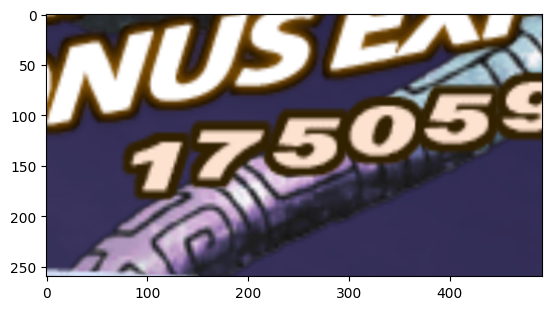

['Marin Karin', 'High Counter', 'Rakunda', 'Auto-Sukukaja', 'Sharp Student']
['Auto-Sukukaja', 'Evil Touch', 'Mind Charge', 'Rakukaja', 'Marakunda']
['Marin Karin', 'Sharp Student', 'High Counter', 'Evade Wind', 'Evil Touch']
['Rakukaja', 'Evil Touch', 'High Counter', 'Salvation', 'Die for Me!']
['Rakukaja', 'Evade Wind', 'Marin Karin', 'Spirit Drain', 'Victory Cry']
['Marin Karin', 'Marakunda', 'Die for Me!', 'Spirit Drain', 'Evade Wind']
['Rakunda', 'Auto-Sukukaja', 'Absorb Slash', 'Marin Karin', 'Mighty Swing']
['Spell Master', 'Evade Wind', 'Marakunda', 'Rakukaja', 'Sharp Student']
['Sharp Student', 'Victory Cry', 'Gale Slash', 'Absorb Slash', 'Die for Me!']
['Mind Charge', 'Auto-Sukukaja', 'Primal Force', 'Rakunda', 'Rakukaja']
['Marin Karin', 'Rakunda', 'Sharp Student', 'Auto-Sukukaja', 'Victory Cry']
['Salvation', 'Rakunda', 'Sharp Student', 'Evil Touch', 'Marin Karin']
['Evade Wind', 'Evil Touch', 'Rakunda', 'Auto-Sukukaja', 'Marin Karin']
['Rakukaja', 'Absorb Slash', 'Sharp St

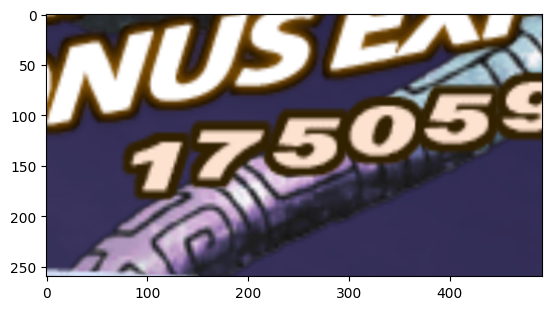

['Bash', 'Power Charge', 'Mabufula', 'Ice Break']
['Apt Pupil', 'Mabufula', 'Enradi', 'Tarukaja']
['Bufudyne', 'Enradi', 'Tarukaja', 'Mabufula']
['Tarukaja', 'Enradi', 'Virus Breath', 'Resist Fire']
['Bufudyne', 'Apt Pupil', 'Resist Fire', 'Mabufula']
['Bufudyne', 'Null Fire', 'Mabufula', 'Tarukaja']
['Resist Fire', 'Null Dark', 'Bufudyne', 'Virus Breath']
['Tarukaja', 'Bufudyne', 'Null Dark', 'Mabufula']
['Apt Pupil', 'Mabufula', 'Bufudyne', 'Virus Breath']
['Tarukaja', 'Bufudyne', 'Enradi', 'Null Dark']
['Bufudyne', 'Mabufula', 'Resist Fire', 'Matarunda']
['Null Dark', 'Bufudyne', 'Mabufula', 'Tarukaja']
['Bufudyne', 'Matarunda', 'Mabufula', 'Apt Pupil']
['Enradi', 'Mabufula', 'Apt Pupil', 'Bufudyne']
['Bash', 'Tarukaja', 'Ice Break', 'Sexy Dance']
['Resist Fire', 'Tarukaja', 'Mabufula', 'Sexy Dance']
['Bufudyne', 'Enradi', 'Ice Break', 'Sexy Dance']
['Bufudyne', 'Mabufula', 'Sexy Dance', 'Virus Breath']
['Mabufula', 'Enradi', 'Null Dark', 'Power Charge']
['Mabufula', 'Bufudyne', 'Ma

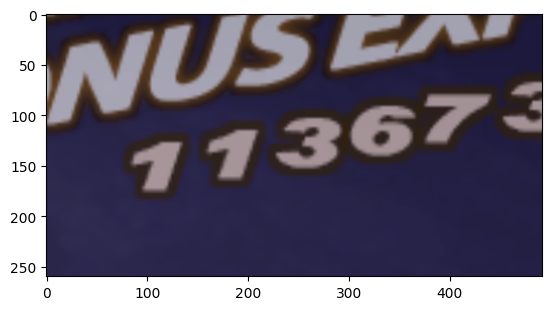

EXP Verification rectangle has changed. Stopping the program.
showing bad pictures


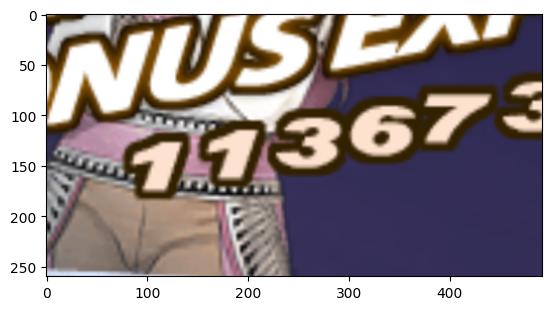

swaping to next save state
['Rakukaja', 'Mabufu', 'Poison Mist', 'Dodge Strike']
['High Counter', 'Poison Mist', 'Mabufu', 'Posumudi']
['Mabufu', 'Ice Boost', 'Power Charge', 'Raging Tiger']
['Mabufu', 'Sukukaja', 'Ice Boost', 'Sonic Punch']
['Mabufu', 'Ice Boost', 'Auto-Masuku', 'Sukukaja']
['Mabufu', 'Power Charge', 'Dodge Strike', 'Rakukaja']
['Mabufu', 'Raging Tiger', 'Me Patra', 'Posumudi']
['Rakukaja', 'Mabufu', 'Auto-Tarukaja', 'Sukukaja']
['Raging Tiger', 'Mabufu', 'Me Patra', 'Dodge Strike']
['Dodge Strike', 'Mabufu', 'Ice Boost', 'Auto-Tarukaja']
['Raging Tiger', 'Me Patra', 'Mabufu', 'Auto-Tarukaja']
['Mabufu', 'Raging Tiger', 'Rakukaja', 'Posumudi']
['Mabufu', 'Dodge Strike', 'Auto-Tarukaja', 'Ice Boost']
['Rakukaja', 'Mabufu', 'Auto-Mataru', 'Sukukaja']
['Mabufu', 'Me Patra', 'Sukukaja', 'Raging Tiger']
['Raging Tiger', 'Sonic Punch', 'Mabufu', 'Ice Boost']
['Mabufu', 'Posumudi', 'Vicious Strike', 'Me Patra']
['Posumudi', 'Raging Tiger', 'Rakukaja', 'Dodge Strike']
['Posum

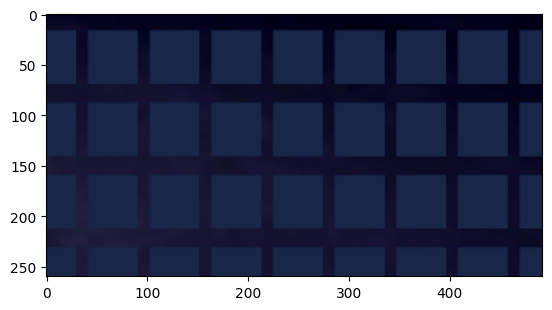

['Sukukaja', 'Mabufu', 'Raging Tiger', 'Auto-Tarukaja']
['Me Patra', 'Mabufu', 'Sonic Punch', 'Poison Mist']
['Mabufu', 'Ice Boost', 'Sukukaja', 'Rakukaja']
['Mabufu', 'Dodge Strike', 'Ice Boost', 'Raging Tiger']
['Mabufu', 'Posumudi', 'Auto-Tarukaja', 'Poison Mist']
['Power Charge', 'Ice Boost', 'Mabufu', 'Me Patra']
['Mabufu', 'Auto-Tarukaja', 'Poison Mist', 'Ice Boost']
['Mabufu', 'Raging Tiger', 'Auto-Masuku', 'High Counter']
['Mabufu', 'Auto-Masuku', 'Vicious Strike', 'Sukukaja']
['Poison Mist', 'Me Patra', 'Power Charge', 'Rakukaja']
['Raging Tiger', 'Mabufu', 'Auto-Tarukaja', 'Ice Boost']
['Auto-Tarukaja', 'Mabufu', 'Raging Tiger', 'Posumudi']
['Ice Boost', 'Mabufu', 'Poison Mist', 'Raging Tiger']
['Sukukaja', 'Mabufu', 'Poison Mist', 'Auto-Mataru']
['Mabufu', 'Sukukaja', 'Posumudi', 'Ice Boost']
['Poison Mist', 'Rakukaja', 'Dodge Strike', 'Me Patra']
['Mabufu', 'Auto-Tarukaja', 'Auto-Mataru', 'Posumudi']
['Mabufu', 'Me Patra', 'Power Charge', 'Ice Boost']
['Mabufu', 'Auto-Taruk

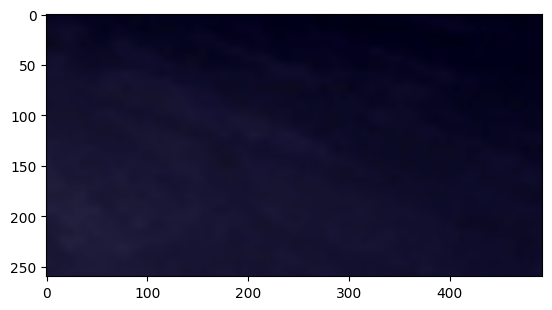

['Niflheim', 'Mudoon', 'Wind Amp', 'Ghastly Wail', 'Tarukaja']
['Evil Smile', 'Tarukaja', 'Niflheim', 'Sukukaja', 'Wind Boost']
['Sukukaja', 'Ghastly Wail', 'Niflheim', 'Patra', 'Ice Amp']
['Evil Smile', 'Niflheim', 'High Counter', 'Patra', 'Recarm']
['Patra', 'Growth 3', 'Null Dark', 'Mudoon', 'Ghastly Wail']
['Sukukaja', 'Wind Boost', 'Diarahan', 'Samsara', 'Patra']
['Null Fear', 'Evil Smile', 'Recarm', 'Patra', 'Mudoon']
['Niflheim', 'Wind Boost', 'Growth 3', 'Patra', 'Sukukaja']
['Samsara', 'Tarukaja', 'Patra', 'Sukukaja', 'Mudoon']
['Wind Amp', 'Sukukaja', 'Tarukaja', 'Niflheim', 'Null Dark']
['Niflheim', 'Sukukaja', 'Tarukaja', 'Recarm', 'Patra']
['Wind Boost', 'Patra', 'Tarukaja', 'Evil Smile', 'Niflheim']
['Diarahan', 'Patra', 'Tarukaja', 'High Counter', 'Niflheim']
['Tarukaja', 'Diarahan', 'Niflheim', 'Sukukaja', 'Null Fear']
['Samsara', 'High Counter', 'Evil Smile', 'Niflheim', 'Patra']
['Recarm', 'Wind Amp', 'Growth 3', 'Patra', 'Niflheim']
['Tarukaja', 'Niflheim', 'Wind Boo

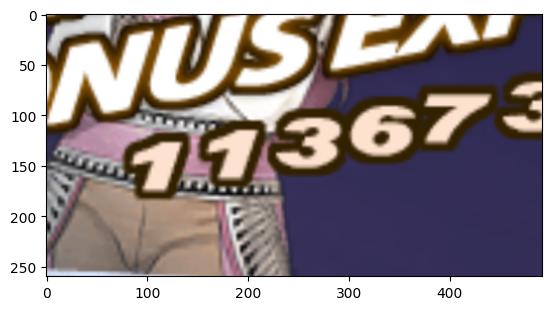

['Bufu', 'Mabufudyne', 'Evade Strike', 'Mediarama']
['Bufu', 'Mabufudyne', 'Sukunda', 'Wind Amp']
['Posumudi', 'Bufu', 'Wind Amp', 'Sukunda']
['Posumudi', 'Mabufudyne', 'Bufu', 'Mediarama']
['Mabufudyne', 'Bufu', 'Raging Tiger', 'Mediarama']
['Raging Tiger', 'Bufu', 'Mabufudyne', 'Counter']
['Counter', 'Bufu', 'Sukunda', 'Raging Tiger']
['Raging Tiger', 'Bufu', 'Mabufudyne', 'Diarahan']
['Bufu', 'Mabufudyne', 'Wind Amp', 'Posumudi']
['Posumudi', 'Bufu', 'Sukunda', 'Mabufudyne']
['Bufu', 'Mabufudyne', 'Sukunda', 'Posumudi']
['Bufu', 'Counter', 'Sukunda', 'Raging Tiger']
['Posumudi', 'Bufu', 'Counter', 'Mabufudyne']
['Posumudi', 'Sukunda', 'Bufu', 'Mabufudyne']
['Bufu', 'Sukunda', 'Mabufudyne', 'Raging Tiger']
['Raging Tiger', 'Sukunda', 'Bufu', 'Diarahan']
['Bufu', 'Raging Tiger', 'Mabufudyne', 'Sukunda']
['Bufu', 'Posumudi', 'Raging Tiger', 'Wind Amp']
['Bufu', 'Evade Strike', 'Diarahan', 'Gigantic Fist']
['Bufu', 'Posumudi', 'Counter', 'Sukunda']
['Bufu', 'Raging Tiger', 'Counter', 'M

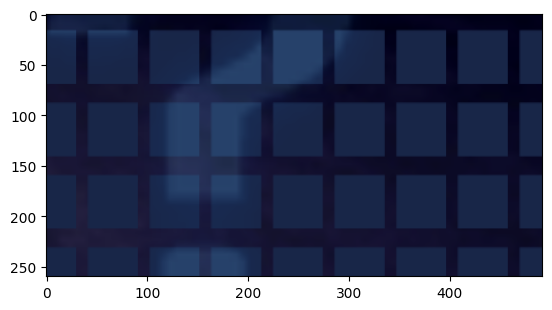

['Wind Boost', 'Mediarahan', 'Trafuri', 'Rakukaja', 'Recarmdra']
['Hamaon', 'Rakukaja', 'Hama Boost', 'Counter', 'Mediarahan']
['Tarukaja', 'Wind Break', 'Rakukaja', 'Akasha Arts', 'Mediarahan']
['Trafuri', 'Rakukaja', 'Counterstrike', 'Tarukaja', 'Wind Amp']
['Counterstrike', 'Wind Boost', 'Trafuri', 'Mind Charge', 'Rakukaja']
['Hamaon', 'Rakukaja', 'Wind Break', 'Counterstrike', 'Tarukaja']
['Rakukaja', 'Wind Boost', 'Wind Break', 'Dekaja', 'Wind Amp']
['Wind Boost', 'Counter', 'Mind Charge', 'Wind Amp', 'Sharp Student']
['Wind Boost', 'Rakukaja', 'Tarukaja', 'Wind Amp', 'Akasha Arts']
['Trafuri', 'Tarukaja', 'Mediarahan', 'Rakukaja', 'Wind Boost']
['Sharp Student', 'Rakukaja', 'Recarmdra', 'Counter', 'Wind Break']
['Mind Charge', 'Wind Amp', 'Counterstrike', 'Rakukaja', 'Wind Boost']
['Mind Charge', 'Rakukaja', 'Sharp Student', 'Wind Boost', 'Wind Amp']
['Salvation', 'Mahamaon', 'Wind Amp', 'Sharp Student', 'Tarukaja']
['Resist Dark', 'Mahamaon', 'Recarmdra', 'Mind Charge', 'Sharp S

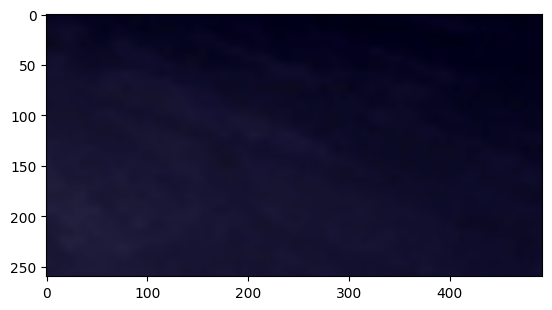

['Tarukaja', 'Wind Boost', 'Counterstrike', 'Resist Dark', 'Wind Break']
Verification rectangle has changed. Stopping the program.
EXP Verification rectangle has changed. Stopping the program.
showing bad pictures


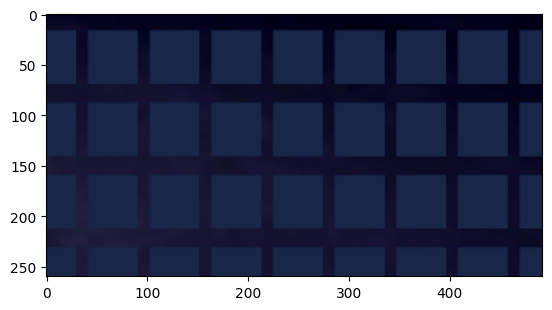

['Rakukaja', 'Recarmdra', 'Salvation', 'Mediarahan', 'Trafuri']
['Wind Boost', 'Hama Boost', 'Wind Break', 'Dekaja', 'Counter']
['Counter', 'Mind Charge', 'Counterstrike', 'Hama Boost', 'Tarukaja']
['Wind Amp', 'Rakukaja', "God's Hand", 'Mind Charge', 'Hama Boost']
['Rakukaja', 'Wind Amp', 'Salvation', 'Dekaja', "God's Hand"]
['Counter', 'Resist Dark', 'Hamaon', 'Recarmdra', 'Mahamaon']
['Wind Break', 'Tarukaja', 'Wind Boost', 'Mediarahan', 'Trafuri']
['Wind Boost', 'Counter', 'Sharp Student', 'Rakukaja', 'Mediarahan']
['Mind Charge', 'Tarukaja', 'Recarmdra', 'Wind Boost', 'Hamaon']
['Sharp Student', 'Wind Break', 'Mahamaon', 'Hama Boost', 'Counter']
['Rakukaja', 'Wind Amp', 'Wind Boost', 'Mind Charge', 'Counter']
['Sharp Student', 'Hamaon', 'Counterstrike', 'Tarukaja', 'Dekaja']
['Recarmdra', 'Rakukaja', 'Mind Charge', 'Counterstrike', 'Tarukaja']
['Rakukaja', 'Wind Boost', 'Tarukaja', 'Sharp Student', 'Mind Charge']
['Wind Amp', 'Tarukaja', 'Mind Charge', 'Counter', 'Rakukaja']
['Cou

In [3]:
sa = SkillAnalyzer(recipes)
sa.cycle()

In [14]:

keys = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12',
    'enter', 'ctrl', 'alt', 'tab', 'shift', 'backspace', 'capslock', 'esc', 'space', 'delete', 'insert', 'home', 'end', 'up', 'down', 'left', 'up',
    'pageup', 'pagedown', 'printscreen', 'pause', 'numlock', 'scrolllock',
]

In [4]:
print(counter)

614


refazer slot 4 

comecar slot 9 do 614